<a href="https://colab.research.google.com/github/rabinatwayana/DL_torchgeo_MMFlood_Segmentation/blob/master/Drive_mmflood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning-based Semantic Flood Mapping using UNet and SegFormer on Multimodal Earth Observation Data

Author: Rabina Twayana

This notebook aims to perform semantic segmentation for flood mapping by training, evaluating, and comparing different deep learning models.

## Environment and Install Packages

The notebook was run in Google Colab. Following packages were installed.

In [ ]:
# Case: Google Colab
# !pip install torchgeo --quiet
# !pip install wandb --quiet

# Case: Local (using conda)
# conda create -n torchgeo_env python=3.11
# conda activate torchgeo_env
# conda install -c conda-forge torchgeo
# !conda install wandb -y

## Import Packages

In [2]:
import os
import warnings

# 1. Silence Intel MKL warnings
os.environ["MKL_DEPRECATED_HELPERS"] = "1"
os.environ["MKL_DEBUG_CPU_TYPE"] = "5" # Optional: forces a specific CPU type to bypass checks

# 2. Silence standard Python and Lightning warnings
warnings.filterwarnings("ignore", ".*Intel MKL WARNING.*")
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger ##https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.WandbLogger.html#lightning.pytorch.loggers.WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchgeo.trainers import SemanticSegmentationTask
from torch.utils.data import DataLoader
from datetime import datetime
from torchgeo.datasets import MMFlood
import json
import pandas as pd
import os
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import kornia.augmentation as K
from torchvision import transforms
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torchgeo.datasets import stack_samples
from torch.utils.data import Subset
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, BatchSampler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/rabinatwayana/miniforge3/envs/torchgeo_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)                # CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)       # Single GPU
        torch.cuda.manual_seed_all(seed)   # Multi-GPU
set_seed(42)  

import os
from lightning.pytorch.loggers import WandbLogger, CSVLogger
# Remember the environment fix for your earlier error
os.environ["WANDB_START_METHOD"] = "thread"
# 1. Local CSV Backup (Safe, won't trigger BrokenPipe)
# csv_logger = CSVLogger(save_dir="local_logs/", name="torchgeo_experiment")

# Make CUDA deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import logging

# Set the logging level for Lightning to ERROR (hides Warnings and Info)
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

## Utility Functiona

In [20]:
import time
from datetime import datetime
from contextlib import contextmanager

class ProjectLogger:
    def __init__(self):
        self.logs = []

    def log(self, msg: str):
        ts = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
        line = f"[{ts}] {msg}"
        self.logs.append(line)
        print(line)

    @contextmanager
    def step(self, name: str):
        # self.log(f"START: {name}")
        start = time.perf_counter()
        yield
        self.log(f"END: {name} (Duration: {time.perf_counter() - start:.2f}s)\n")

    # def save(self, output_dir: str, filename: str):
    #     try:
    #         if output_dir.startswith(("s3://", "s3a://")):
    #             path = f"{output_dir.rstrip('/')}/{filename}"
    #             with fs.open(path, "w") as f:
    #                 f.write("\n".join(self.logs))
    #             print(f"Log saved to {path}")
    #     except Exception as e:
    #         print(f"Failed to save logs to S3: {e}")

    #     try:
    #         os.makedirs("logs", exist_ok=True)
    #         local_path = os.path.join("logs", filename)
    #         with open(local_path, "w") as f:
    #             f.write("\n".join(self.logs))
    #         print(f"Log saved locally: {local_path}")
    #     except Exception as e:
    #         print(f"Failed to save logs to local: {e}")


custom_logger = ProjectLogger()
    
def get_activations_stats(annot_path):
    # Load JSON
    with open(annot_path, "r") as f:
        data = json.load(f)

    # Convert dict to DataFrame
    df = pd.DataFrame.from_dict(data, orient="index")
    print("Column List: ",list(df.columns))

    country_counts = df["country"].value_counts()
    total_countries = country_counts.shape[0]

    print(f"\nTotal Countries: {total_countries}")


    print(f"\nTotal activations: {len(df)}")

    subset_counts = df["subset"].value_counts()
    print("\nTotal train/test/val count\n",subset_counts)



    table_counts = pd.crosstab(
        df["country"],
        df["subset"]
    )
    table_counts["total"]=table_counts["train"]+table_counts["test"]+table_counts["val"]
    print("\nCountry wise Train/Test/Val activation count ")
    table_counts_sorted = table_counts.sort_values(
        by="test",
        ascending=False
    )
    print(table_counts_sorted)

    # Reset index to keep activation ID
    # df = df.reset_index().rename(columns={"index": "activation_id"})


def run_data_selection(original_json_path, new_json_path, selected_countries=[], delete_test_activations=[],train_to_val_activations=[] ):
    # Paths
    # root = Path("data/activations")  # path to your dataset
    # original_json =  "data/activations.json"
    # new_json = "data/selected_activations.json"

    # Load existing annotations
    with open(original_json_path) as f:
        metadata = json.load(f)

    # Filter tiles: remove or ignore tiles with empty hydro folders
    selected_metadata = {}
    for tile_id, tile_info in metadata.items():
        if tile_info["country"] in selected_countries:
            selected_metadata[tile_id]=tile_info

    for tile_id in list(selected_metadata.keys()):  # make a copy of keys
        if tile_id in delete_test_activations:
            print("yes")
            del selected_metadata[tile_id]

    # selected_metadata_2 = {}
    # print(selected_metadata.items())
    # for tile_id, tile_info in selected_metadata.items():
    #     if tile_id in delete_test_activations:
    #         print("yes")
    #         continue
    #     selected_metadata_2[tile_id]=tile_info

    updated_metadata = {}
    for tile_id, tile_info in selected_metadata.items():
        if tile_id in train_to_val_activations:
            tile_info["subset"]="val"
            updated_metadata[tile_id]=tile_info

    # # Save new JSON
    with open(new_json_path, "w") as f:
        json.dump(selected_metadata, f, indent=4)


def create_selected_data_folder(act_json_path, activations_dir, target_dir):
    # Load metadata
    with open(act_json_path) as f:
        metadata = json.load(f)

    df = pd.DataFrame.from_dict(metadata, orient="index")
    df = df.reset_index().rename(columns={"index": "activation_id"})
    activation_ids = df["activation_id"].astype(str).tolist()

    os.makedirs(target_dir, exist_ok=True)

    copied = 0
    missing = []

    # List folders once (much faster)
    all_folders = [
        d for d in os.listdir(activations_dir)
        if os.path.isdir(os.path.join(activations_dir, d))
    ]

    for act_id in activation_ids:
        # Find matching folders
        matched = [d for d in all_folders if d.startswith(act_id)]

        if not matched:
            missing.append(act_id)
            continue

        for folder in matched:
            # print(folder)
            src = os.path.join(activations_dir, folder)
            dst = os.path.join(target_dir, folder)

            if not os.path.exists(dst):
                shutil.copytree(src, dst)
                copied += 1

    print(f"Copied {copied} folders")
    if missing:
        print(f"No folder found for  activation IDs: {missing}")

def plot_graph(metric_file_path):
    # 1. Load the data
    df = pd.read_csv(metric_file_path)

    # 2. Group by 'step' to merge the separate train and val rows
    # 'first()' picks the non-null value for each metric at each step
    metrics = df.groupby("step").first().reset_index()

    # 3. Create the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss (Train vs Val)
    ax1.plot(metrics["step"], metrics["train_loss"], label="Train Loss", marker='o', linestyle='-')
    ax1.plot(metrics["step"], metrics["val_loss"], label="Val Loss", marker='o', linestyle='-')
    ax1.set_title("Loss over Steps")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Accuracy (Train vs Val)
    ax2.plot(metrics["step"], metrics["train_BinaryAccuracy"], label="Train Acc", marker='s', linestyle='--')
    ax2.plot(metrics["step"], metrics["val_BinaryAccuracy"], label="Val Acc", marker='s', linestyle='--')
    ax2.set_title("Binary Accuracy over Steps")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## Dataset
MMFlood dataset is a multimodal flood delineation dataset (Montello et al., 2022).

 Some Sentinel-1 tiles have missing data, which are automatically set to 0. Corresponding pixels in masks are set to 255 and should be ignored in performance computation.

Dataset features:

- 1,748 Sentinel-1 tiles of varying pixel dimensions

- Multimodal dataset (Sentinel-1, DEMs and hydrography maps (available for 1,012 tiles out of 1,748))

- 95 flood events from 42 different countries ranging from 2014 to 2021

- Flood delineation maps (ground truth) is obtained from Copernicus EMS

- Missing data in Sentinel-1 tiles are set to 0 and corrsponding pixels in masks are set to 255 (must ignored in performance computation)  

- Image size is 2000 * 2000

Dataset classes:

- no flood

- flood



### Download data

If data is already exist in root dir, download will be skipped. Data download failed when I tried in colab. So downlaod and data subset was done locally.

In [ ]:
with custom_logger.step("Data download "):
    dataset = MMFlood(
        root="data",   # where data will be stored
        download=True,         # this triggers download
        checksum=True          # optional but recommended
    )


In [ ]:
get_activations_stats("data/original_activations.json")

### Removed activations from TEST dataset
- France (EMSR492, EMSR411)
- Italy (EMSR333,EMSR141, EMSR330,EMSR496,EMSR548)
- Ireland (EMSR149)

### Move from train to val
- Germany (EMSR497)
- Ireland (EMSR156)
- Greece (EMSR117)

In [ ]:
selected_countries= ["Greece", "Spain", "France", "Italy", "Germany", "UK", "Australia", "Ireland"]
delete_test_activations = ['EMSR492','EMSR411','EMSR333','EMSR141','EMSR330','EMSR496','EMSR548','EMSR149']
train_to_val_activations = ['EMSR497','EMSR156','EMSR117']

In [ ]:
# MMFlood reads the activations.json file inside data root directory.
os.rename("data/activations.json", "data/original_activations.json")

In [ ]:
original_json_path = "data/original_activations.json"
new_json_path = "data/activations.json"

run_data_selection(original_json_path, new_json_path, selected_countries, delete_test_activations,train_to_val_activations )
get_activations_stats(new_json_path)

In [ ]:

with custom_logger.step("Copying selected activations in new folder"):
    create_selected_data_folder( act_json_path="data/activations.json",activations_dir="data/activations",target_dir="selected_data/activations")


In [ ]:
shutil.move("data/activations.json", "selected_data/activations.json")

## Deeplearning Models: SegFormer
SegFormer is a simple, efficient and powerful semantic segmentation method. It unifies Transformers with lightweight multilayer perceptron (MLP) decoders.

Features: 
(1) a hierarchical Transformer encoder to generate high-resolution coarse features and low-resolution fine features; and 

(2) a lightweight All-MLP decoder to fuse these multi-level features to produce the final semantic segmentation mask.
1) Positional-encoding-free and hierarchical Transformer encoder.  
    - Encoder can easily adapt to arbitrary test resolutions without impacting the performance. 
    - The hierarchical part enables the encoder to generate both high-resolution fine features and low-resolution coarse features (contrast to ViT this is in contrast to ViT that can only produce single low-resolution feature maps with fixed resolutions)
    
    . Second, we propose a 
comprises a novel hierarchically structured Transformer encoder which outputs multiscale features. It does not need positional encoding, thereby avoiding the interpolation of positional codes which leads to decreased performance when the testing resolution differs from training. 

2) A lightweight All-MLP decoder design that yields a powerful representation without complex and computationally demanding modules.

SegFormer avoids complex decoders. The proposed MLP decoder aggregates information from different layers, and thus combining both local attention and global attention to render powerful representations.  lightweight MLP decoder where the key idea is to take advantage of the Transformer-induced features where the attentions of lower layers tend to stay local, whereas the ones of the highest layers are highly non-local. By aggregating the information from different layers, the MLP decoder combines both local and global attention. 

Series of models available from SegFormer-B0 to SegFormer-B5.


Given an image of size H × W × 3, we first divide it into patches of size 4 × 4. Contrary to ViT that uses patches of size 16 × 16, using smaller patches favors the dense prediction task. We then use these patches as input to the hierarchical Transformer encoder to obtain multi-level features at {1/4, 1/8, 1/16, 1/32} of the original image resolution. We then pass these multi-level features to the All-MLP decoder to predict the segmentation mask at a H  4 ×W  4 × Ncls resolution, where Ncls is the number of categories. In the rest of this section, we detail the proposed encoder and decoder designs and summarize the main differences between our approach and SETR.

Hierarchical Transformer Encoder  We design a series of Mix Transformer encoders (MiT), MiT-B0 to MiT-B5, with the same architecture but different sizes.

we perform patch merging to obtain a hierarchical feature map Fi with a  resolution of H  2i+1 × W  2i+1 × Ci, where i ∈ {1, 2, 3, 4}, and Ci+1 is larger than Ci.

MiT: Mix Transformer

https://medium.com/geekculture/semantic-segmentation-with-segformer-2501543d2be4

SegFormer is a modern semantic segmentation model that makes two key innovations to deliver high accuracy, speed, and robustness, all in an easy-to-use package: https://www.labellerr.com/blog/segformer/

    Hierarchical, Positional-Encoding-Free Transformer Encoder

    Instead of using fixed positional embeddings (which must be interpolated at test time and can hurt performance when image sizes change), SegFormer’s encoder learns positional information implicitly via its feed-forward blocks.
    It processes an input image at four different scales so you get both fine (high-resolution) and coarse (low-resolution) feature maps, much like a CNN backbone but without handcrafted modules.

    Lightweight All-MLP Decoder

    All it uses are simple multi-layer perceptron (MLP) layers: no complex convolutional or attention modules.
    It takes the multi-scale features from the encoder, projects them to a common channel size, upsamples to 1/4 resolution, concatenates them, and applies just two more MLPs: one for feature fusion and one to predict the final per-pixel class scores. This yields powerful representations by combining both local cues (lower layers) and global context (higher layers)



![Flood map](segformer_architect.png)

![Flood map](seg_b0_5.png)

Figure: Segformer Model Architecture (Source: (Xie et al., 2021))

FFN- Feed Forward Network


Official github: https://github.com/NVlabs/SegFormer

Paper: https://arxiv.org/abs/2105.15203



Zero-shot robustness (together)

👉 How well the model generalizes to unseen conditions without retraining.

Witnessing the great success in natural language processing (NLP), there has been a recent surge of interest to introduce Transformers to vision tasks.

SETR adopts ViT as a backbone and incorporates several CNN decoders to enlarge feature resolution. Despite the good performance, ViT has some limitations: 1) ViT outputs single-scale low-resolution features instead of multi-scale ones. 2) It has high computation cost on large images. To address these limitations, Wang et al. [8] proposed a pyramid vision Transformer (PVT), a natural extension of ViT with pyramid structures for dense prediction. PVT shows considerable improvements over the ResNet counterpart on object detection and semantic segmentation. However, together with other emerging methods such as Swin Transformer [9] and Twins [10], these methods mainly consider the design of the Transformer encoder, neglecting the contribution of the decoder for further improvements.  This paper introduces SegFormer, a cutting-edge Transformer framework for semantic segmentation that jointly considers efficiency, accuracy, and robustness. In contrast to previous methods, our framework redesigns both the encoder and the decoder. The key novelties of our approach are:  • A novel positional-encoding-free and hierarchical Transformer encoder.  • A lightweight All-MLP decoder design that yields a powerful representation without complex and computationally demanding modules.  • As shown in Figure 1, SegFormer sets new a state-of-the-art in terms o

## Train Model

In [6]:


def get_mmflood_normalize(include_dem=False, include_hydro=False):
    # https://torchgeo.readthedocs.io/en/stable/_modules/torchgeo/datamodules/mmflood.html#MMFloodDataModule.__init__
    # TorchGeo MMFlood stats (center = median, plus std). Order: [VV, VH, DEM, hydro]
    center = [0.11694544, 0.02515762]
    std    = [2.4050937, 0.22703391]

    if include_dem:
        center.append(86.0)
        std.append(242.74332)

    if include_hydro:
        center.append(0.0)
        std.append(0.14825067)

    return transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(center,std)])


def plot_sample(coords, dataset):
    # Get bounding box
    xs, ys = zip(*coords)
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)

    # train_dataset.transforms = None
    # Spatial resolution (adjust to match your dataset!)
    xres = 0.001   # ~100 meters at equator
    yres = 0.001

    # Time range (example: full year 2023, daily steps)
    t_start = pd.Timestamp("2014-01-01")
    t_end   = pd.Timestamp("2021-12-31")
    tres    = 1   # or "P1D"


    query = (
        slice(xmin, xmax, xres),
        slice(ymin, ymax, yres),
        # slice(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-12-31"), 1)
        slice(t_start, t_end, tres)

    )

    train_samples= dataset.__getitem__(query=query) # train_samples['image'], len(train_samples)
    fig = dataset.plot(
        sample=train_samples,
        show_titles=True,          # default: True
        suptitle="MMFlood Sample Visualization"  # optional
    )

    # 2. Show the figure (or save it)
    plt.show()
    return 



In [7]:
# from google.colab import drive
# drive.mount('/content/drive') #os.listdir('/content/drive'

# root_data_dir="/content/drive/MyDrive/MMFlood/selected_data"
root_data_dir= "selected_data/"
include_dem = True
include_hydro = False
apply_normalize = False

In [8]:
def load_dataset(root_data_dir, include_hydro, include_dem):
    with custom_logger.step("Loading train dataset"):
        train_dataset = MMFlood(root=root_data_dir, split="train", include_hydro=include_hydro, include_dem=include_dem, download=False)
    with custom_logger.step("Loading val dataset"):
        val_dataset = MMFlood(root=root_data_dir, split="val", include_hydro=include_hydro,include_dem=include_dem, download=False)
    with custom_logger.step("Loading test dataset"):
        test_dataset = MMFlood(root=root_data_dir, split="test", include_hydro=include_hydro,include_dem=include_dem, download=False)

        
    print("Train samples:", len(train_dataset))
    print("Val samples:", len(val_dataset))
    print("Test samples:", len(test_dataset))
    return train_dataset, val_dataset, test_dataset


train_dataset, val_dataset, test_dataset = load_dataset(
    root_data_dir=root_data_dir, 
    include_hydro=include_hydro, 
    include_dem=include_dem
    )

if apply_normalize==True:
    normalize=get_mmflood_normalize(include_dem=include_dem, include_hydro=include_hydro)
    train_dataset.transforms = normalize
    val_dataset.transforms = normalize
    test_dataset.transforms = normalize
else:
    train_dataset.transforms = None
    val_dataset.transforms = None
    test_dataset.transforms = None

[2026-01-23 21:02:01] END: Loading train dataset (Duration: 2.80s)

[2026-01-23 21:02:02] END: Loading val dataset (Duration: 0.65s)

[2026-01-23 21:02:02] END: Loading test dataset (Duration: 0.62s)

Train samples: 551
Val samples: 127
Test samples: 109


In [ ]:
# get geometry
geom = train_dataset.index['geometry'].iloc[12]
print(list(geom.exterior.coords))

/Users/rabinatwayana/miniforge3/envs/torchgeo_env/lib/python3.11/site-packages/torchgeo/datasets/mmflood.py:310: RuntimeWarning: invalid value encountered in divide
  ratio = co_polarization / cross_polarization


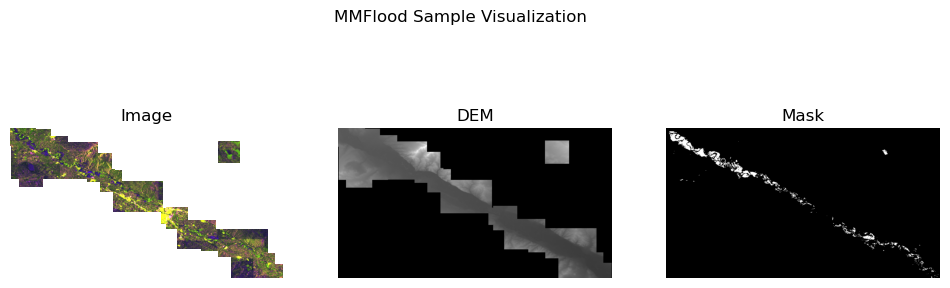

In [9]:
# Polygon coordinates
coords = [
    (-0.47885627639017, 41.44272176506629),
    (-0.47885627639017, 41.493588703533106),
    (-0.54734375, 41.493588703533106),
    (-0.54734375, 41.44272176506629),
    (-0.47885627639017, 41.44272176506629),
    (-1.3079116013156395, 41.8822770409637),
    (-1.3079116013156395, 41.945550784988),
    (-1.3991635179195094, 41.945550784988),
    (-1.3991635179195094, 41.8822770409637),
    (-1.3079116013156395, 41.8822770409637)
]

plot_sample(coords=coords, dataset=train_dataset)

In [10]:
from torchgeo.samplers import GridGeoSampler
from torch.utils.data import Sampler



class NonZeroGridSampler(Sampler):
    def __init__(self, dataset, size, stride):
        self.dataset = dataset

        self.grid_sampler = GridGeoSampler(dataset, size=size, stride=stride)
        print("No of samples including zero patches", len(self.grid_sampler))
        with custom_logger.step("Only keeping non-zero patches"):
            self.valid_indices = []
            # Iterate over GridGeoSampler to filter valid patches
            for idx, bbox in enumerate(self.grid_sampler):
                sample = dataset[bbox]         # get the patch (CHW tensor)
                img_patch = sample['image']

                total_pixels = img_patch.numel()          # total number of pixels
                zero_pixels = (img_patch == 0).sum().item()  # count zero pixels
                zero_ratio = zero_pixels / total_pixels       # fraction of zeros

                # Keep patch only if <= 50% pixels are zero
                if zero_ratio <= 0.5:
                    self.valid_indices.append(bbox)

    def __len__(self):
        return len(self.valid_indices)
    
    def __iter__(self):
        return iter(self.valid_indices)


# from torch.utils.data import DataLoader, BatchSampler

# sampler = NonZeroGridSampler(train_dataset, size=512, stride=512)
# print("Number of valid patches:", len(sampler))
# batch_sampler = BatchSampler(sampler, batch_size=8, drop_last=False)

In [11]:
def get_metrics(train_metrics, test_metrics):
    print(train_metrics)
    # Extract all metrics (fix test_result access)
    train_acc = train_metrics['train_BinaryAccuracy'].item()
    val_acc = train_metrics['val_BinaryAccuracy'].item()
    train_loss = train_metrics['train_loss'].item()
    val_loss = train_metrics['val_loss'].item()
    train_ji = train_metrics['train_BinaryJaccardIndex'].item()
    val_ji = train_metrics['val_BinaryJaccardIndex'].item()

    train_precision = train_metrics['train_BinaryPrecision'].item()
    val_precision = train_metrics['train_BinaryPrecision'].item()
    train_recall = train_metrics['train_BinaryRecall'].item()
    val_recall = train_metrics['val_BinaryRecall'].item()
    train_f1 = train_metrics['train_BinaryF1Score'].item()
    val_f1 = train_metrics['val_BinaryF1Score'].item()

    
    test_loss = test_metrics['test_loss']
    test_acc = test_metrics['test_BinaryAccuracy']
    test_ji = test_metrics['test_BinaryJaccardIndex']
    test_precision = test_metrics['test_BinaryPrecision']
    test_recall = test_metrics['test_BinaryRecall']
    test_f1 = test_metrics['test_BinaryF1Score']




    metrics_data = {
        'Split': ['Train', 'Validation', 'Test'],
        'Accuracy': [f"{train_acc:.2f}", f"{val_acc:.2f}", f"{test_acc:.2f}"],
        'Loss': [f"{train_loss:.2f}", f"{val_loss:.2f}", f"{test_loss:.2f}"],
        'JaccardIndex': [f"{train_ji:.2f}", f"{val_ji:.2f}", f"{test_ji:.2f}"],
        'Precision': [f"{train_precision:.2f}", f"{val_precision:.2f}", f"{test_precision:.2f}"],
        'Recall': [f"{train_recall:.2f}", f"{val_recall:.2f}", f"{test_recall:.2f}"],
        'F1Score': [f"{train_f1:.2f}", f"{val_f1:.2f}", f"{test_f1:.2f}"],
    }

    df_metrics = pd.DataFrame(metrics_data)
    print(df_metrics)
    return df_metrics

In [15]:
import os
# Set this at the very top of your notebook/script
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
def check_hardware_info():
    import torch

    # Dynamic Hardware Detection
    if torch.cuda.is_available():
        # Google Colab / Linux / Windows with NVIDIA
        current_accel = "gpu"
        current_devices = -1  # Use all available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Found {num_gpus} GPU(s):")
        for i in range(num_gpus):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    # elif torch.backends.mps.is_available():
    #     # Mac M1/M2/M3 chips
    #     current_accel = "mps"
    #     current_devices = 1   # MPS usually works best with 1 device in Lightning
    else:
        # Default fallback
        current_accel = "cpu"
        current_devices = 1
        
    print(f"Current accelerator:{current_accel} , Current number of devices: {current_devices}")
    return current_accel, current_devices

In [ ]:
from torchgeo.trainers import SemanticSegmentationTask
from torchmetrics import MetricCollection, Precision, Recall, F1Score

class EnhancedSegmentationTask(SemanticSegmentationTask):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # Define common settings for the metrics
        # Using task="binary" for your specific use case
        metric_kwargs = {
            "task": "binary",
            "ignore_index": self.hparams.get("ignore_index")
        }

        # 1. Create the Metric Collections
        metrics = MetricCollection([
            Precision(**metric_kwargs),
            Recall(**metric_kwargs),
            F1Score(**metric_kwargs)
        ])

        # 2. Add them to the internal TorchGeo metric keepers
        # .clone(prefix=...) ensures they show up as 'val_Precision', etc.
        self.train_metrics.add_metrics(metrics.clone())
        self.val_metrics.add_metrics(metrics.clone())
        self.test_metrics.add_metrics(metrics.clone())

def train_model(
    model_name,
    input_type,
    train_dataset,
    val_dataset,
    test_dataset,
    max_epochs = 50,
    batch_size = 8,
    patch_size = 256,          # size of random patches (in pixels)
    num_train_patches = 10000, # how many random patches per epoch
    num_val_patches = 2000,
    num_test_patches=1000,
    in_channels = 3,           # IMPORTANT: set this to your actual number of input bands!
    # num_classes = 2,
    learning_rate = 0.001,
    patience=5,
    freeze_backbone = True,      # keep encoder frozen
    freeze_decoder = False,
    wandb_logging = True,

):
    
    """
    Train a TorchGeo semantic segmentation model (UNet or SegFormer) with proper geospatial sampling.

    Args:
        model_name (str): 'unet' or 'segformer'
        input_type (str): description of input bands (used for logging/checkpoint naming)
        train_dataset, val_dataset: TorchGeo geospatial datasets (e.g. MMFlood or IntersectionDataset)
        max_epochs (int): number of training epochs
        batch_size (int): batch size
        patch_size (int): size of random patches (square)
        num_train_patches (int): number of random patches per epoch for training
        num_val_patches (int): number of random patches per epoch for validation
        in_channels (int): number of input channels (bands) — MUST match your data!
        num_classes (int): number of output classes (including background if needed)
        learning_rate (float): initial learning rate

    Returns:
        str: path to the best saved checkpoint
    """
    # 1. Create proper TorchGeo samplers (this fixes the TypeError!)

    # indices = list(range(len(train_dataset)))
    # indices = list(range(10))
    # train_subset = Subset(train_dataset, indices)
    # test_subset = Subset(test_dataset, indices)
    # val_subset = Subset(val_dataset, indices)

    current_accelerator, current_devices =check_hardware_info()
    
    train_batch_sampler = RandomGeoSampler(
        train_dataset,
        size=patch_size,
        length=num_train_patches, #The dataset is continuous (large images, maps, rasters), You don’t have a fixed list of samples. sampler will generate num_train_patches patches per epoch
    )

    val_batch_sampler = RandomGeoSampler(
        val_dataset,
        size=patch_size,
        length=num_val_patches,
    )

    test_batch_sampler =RandomGeoSampler(
        test_dataset,
        size=patch_size,
        length=num_test_patches,
    )


    # train_sampler=NonZeroGridSampler(train_dataset, size=patch_size, stride=patch_size)
    # val_sampler =  NonZeroGridSampler(val_dataset, size=patch_size, stride=patch_size)
    # test_sampler =  NonZeroGridSampler(test_dataset, size=patch_size, stride=patch_size)


    # class ShuffledBatchSampler(BatchSampler):
    #     def __iter__(self):
    #         batches = list(super().__iter__())
    #         np.random.shuffle(batches)
    #         for batch in batches:
    #             yield batch

    # train_batch_sampler = ShuffledBatchSampler(train_sampler, batch_size=8, drop_last=False)
    # val_batch_sampler = BatchSampler(val_sampler, batch_size=8, drop_last=False)
    # test_batch_sampler = BatchSampler(test_sampler, batch_size=8, drop_last=False)


    train_loader = DataLoader(
        train_dataset,
        # batch_size=batch_size,
        sampler=train_batch_sampler, #train_sampler,
        num_workers=2,
        pin_memory=True,
        collate_fn=stack_samples,
    )

    num_batches = len(train_loader)
    print(f"Number of batches: {num_batches}")

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        sampler=val_batch_sampler,
        num_workers=4,
        pin_memory=True,
        collate_fn=stack_samples,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        sampler=test_batch_sampler,
        num_workers=4,
        pin_memory=True,
        collate_fn=stack_samples,
    )

    # 3. Dynamic Weights & Biases logger
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name=f"{model_name}_{input_type}_{timestamp}"
    if wandb_logging:
        wandb_logger = WandbLogger(
            project="MMFlood_DL_Experiments",
            name=experiment_name,
            log_model="all",  # optional: log best model
            config = {
            "model_name": model_name,      # e.g., "segformer" or "unet"
            "input_type": input_type,      # e.g., "s1_dem", "s1_dem_hydro", etc.

            # training setup
            "max_epochs": max_epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,

            # data sampling (TorchGeo-style patch sampling)
            "patch_size": patch_size,
            "num_train_patches": num_train_patches,
            "num_val_patches": num_val_patches,

            # dataset modalities (helps you debug channel mismatches)
            "include_dem": bool(getattr(train_dataset, "include_dem", False)),
            "include_hydro": bool(getattr(train_dataset, "include_hydro", False)),

            "freeze_backbone": freeze_backbone,
            "freeze_decoder": freeze_decoder
        }
        )
    csv_logger = CSVLogger(
        save_dir="local_logs", 
        name=experiment_name, 
        version=""
    )

    early_stop_callback = EarlyStopping(
        monitor="val_loss",   # Metric to watch (must be logged in your task)
        min_delta=0.00,       # Minimum change to qualify as an improvement
        patience=10,          # How many epochs to wait before stopping
        verbose=True,         # Prints a message when stopping
        mode="min"            # 'min' for loss, 'max' for accuracy/IOU
    )


    # 4. Checkpoint callback (saves best model based on val IoU)
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        filename=f"best-{model_name}-ep{{epoch:02d}}",
        dirpath=f"checkpoints/{experiment_name}",
        auto_insert_metric_name=False,
    )

    # 5. Create the LightningModule (SemanticSegmentationTask)
    task = EnhancedSegmentationTask(
        model=model_name,           # "unet" or "segformer"
        backbone="mit_b0",        # used for UNet; ignored or optional for SegFormer
        weights=True,
        in_channels=in_channels,    # ← CRITICAL: must match your actual input bands!
        task= "binary",
        # num_classes=num_classes,
        loss= "bce", #"ce",                  # cross-entropy
        ignore_index=255,           # usually used for invalid/no-data pixels
        lr=learning_rate, # How long the scheduler waits before reducing the learning rate if the metric (e.g., val_loss) stops improving.
        patience = patience,
        freeze_backbone = freeze_backbone,      # keep encoder frozen
        freeze_decoder = freeze_decoder      # train decoder + head
    )

    # 6. Initialize PyTorch Lightning Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator=current_accelerator,         # "gpu", "cpu", "mps"...
        devices=current_devices,
        logger= [wandb_logger, csv_logger] if wandb_logging else csv_logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=num_batches 
    )

    with custom_logger.step("Model training"):
        trainer.fit(
            model=task,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader,
        )
    
    train_metrics= trainer.callback_metrics

    with custom_logger.step("Model testing"):
        test_metrics = trainer.test(
            model=task,
            dataloaders=test_loader,  # ← Your test dataloader
            ckpt_path="best"          # Uses your best checkpoint automatically
        )

    print(f"Best model path: {checkpoint_callback.best_model_path}")
    print(f"Logs saved in {csv_logger.log_dir}")

    # 8. Return path to the best checkpoint
    return trainer, task, train_metrics, test_metrics[0]





In [ ]:
# Example 2: Train SegFormer
trainer, task, train_metrics, test_metrics = train_model(
    model_name="segformer",
    input_type="s1_dem",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    max_epochs=2, #add patience
    patience=2,
    batch_size=4,
    patch_size=256,
    in_channels=3,          # ← CHANGE THIS to match your actual number of bands!
    # num_classes=2,
    num_train_patches=5, # how many random patches per epoch
    num_val_patches=5,
    num_test_patches=5,
    wandb_logging=True,
    freeze_backbone = True,      # keep encoder frozen
    freeze_decoder = False
)


Current accelerator:cpu , Current number of devices: 1
Number of batches: 5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: Currently logged in as: rabinatwayana123 (rabinatwayana123-paris-lodron-universit-t-salzburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Sanity Checking: |          | 0/? [00:00<?, ?it/s]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanc

Metric val_loss improved. New best score: 0.292


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s, v_num=ea2_]        Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.284


Epoch 1: 100%|██████████| 5/5 [00:34<00:00,  0.15it/s, v_num=ea2_]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:34<00:00,  0.15it/s, v_num=ea2_]


Restoring states from the checkpoint path at ./MMFlood_DL_Experiments/inwqaea2/checkpoints/epoch=1-step=10.ckpt
Loaded model weights from the checkpoint at ./MMFlood_DL_Experiments/inwqaea2/checkpoints/epoch=1-step=10.ckpt


[2026-01-23 21:04:28] END: Model training (Duration: 91.60s)

Testing: |          | 0/? [00:00<?, ?it/s]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI M

In [18]:
metrics_1= get_metrics(train_metrics, test_metrics)

{'train_BinaryAccuracy': tensor(0.8162), 'train_BinaryJaccardIndex': tensor(0.), 'train_BinaryPrecision': tensor(0.), 'train_BinaryRecall': tensor(0.), 'train_BinaryF1Score': tensor(0.), 'train_loss': tensor(0.3642), 'val_BinaryAccuracy': tensor(0.9511), 'val_BinaryJaccardIndex': tensor(0.), 'val_BinaryPrecision': tensor(0.), 'val_BinaryRecall': tensor(0.), 'val_BinaryF1Score': tensor(0.), 'val_loss': tensor(0.2840)}
        Split Accuracy  Loss JaccardIndex Precision Recall F1Score
0       Train     0.82  0.36         0.00      0.00   0.00    0.00
1  Validation     0.95  0.28         0.00      0.00   0.00    0.00
2        Test     0.94  0.28         0.02      0.12   0.03    0.05


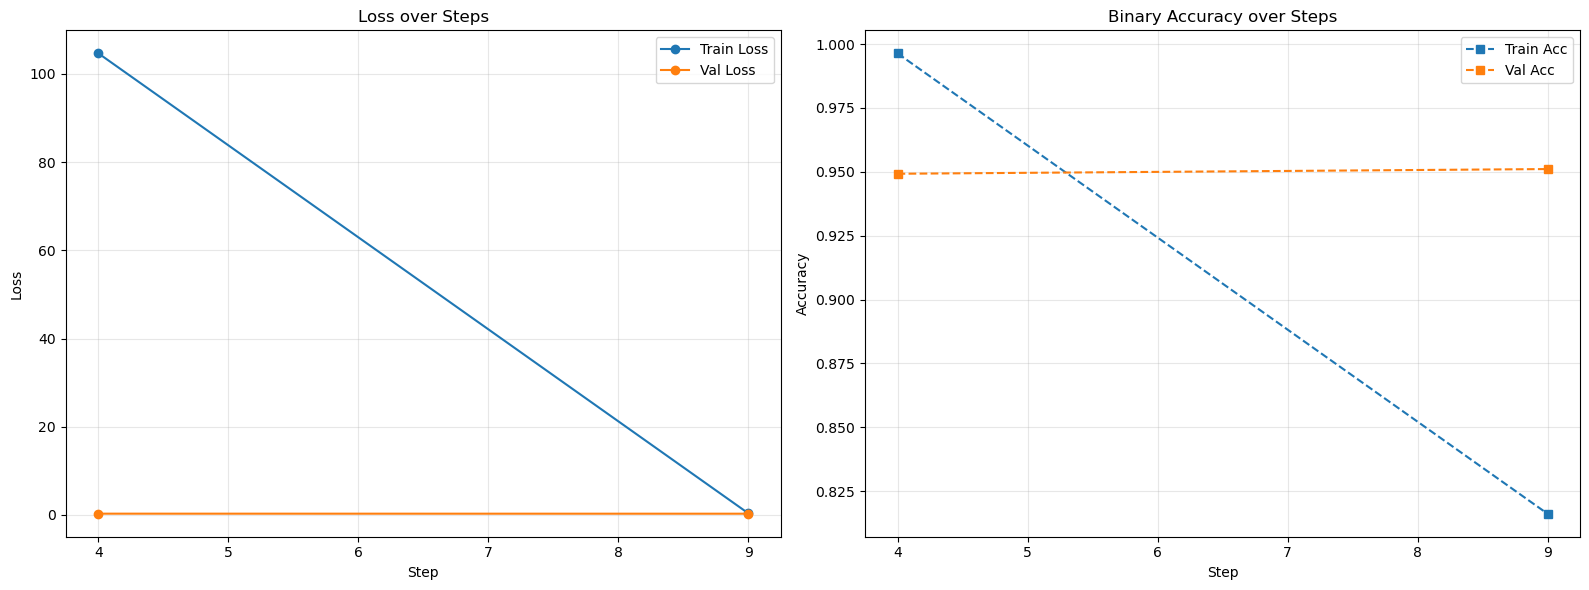

In [21]:
plot_graph("local_logs/segformer_s1_dem_20260123_220256/metrics.csv")

## References
Montello, F., Arnaudo, E., & Rossi, C. (2022). MMFlood: A Multimodal Dataset for Flood Delineation From Satellite Imagery. IEEE Access, 10, 96774–96787. https://doi.org/10.1109/ACCESS.2022.3205419

Xie, E., Wang, W., Yu, Z., Anandkumar, A., Alvarez, J. M., & Luo, P. (2021). SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers (No. arXiv:2105.15203). arXiv. https://doi.org/10.48550/arXiv.2105.15203



